# Introducing Decision Trees

Tree-based algorithms have several advantages:

1. Can capture complex non-linearities without imposing any explicit structure (e.g. cross-terms in a linear regression)
2. Insensitive to feature scale
3. Easily handle a mix of categorical and continuous data
4. Fast
5. Can be somewhat interpretable 
6. Random forests can give a measure of feature importance

**Major disadvantage:**

- *Prone to overfitting without regularization or some kind of ensemble averaging, e.g. bagging*


We'll also discuss:

- Basic greedy algorithm for constructing a tree
- Training and visualizing trees in Python
- Regularization
- Bagging and the Random Forest (later)

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [71]:
from sklearn import tree

## Start with Regression Task

Consider a regression task on polynomial data + noise:

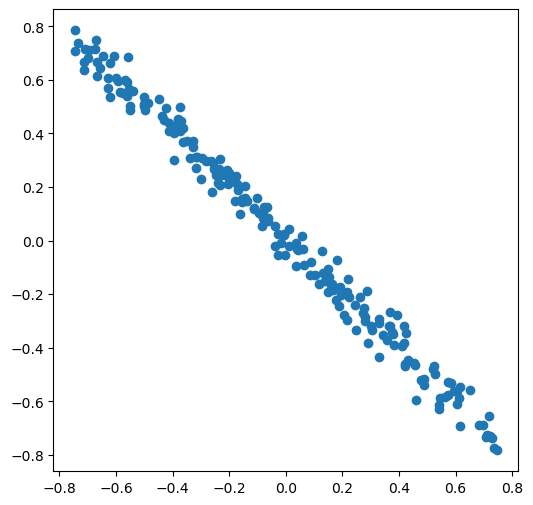

In [100]:
from sklearn.tree import DecisionTreeRegressor

#Make random polynomial data
#np.random.seed(42)

N = 200
#Random x data
x = np.random.uniform(-.75,.75,N)
x.sort()

#Polynomial:
y = 0*x + 1*x**2 + .5*x**3 + np.random.normal(loc=0, scale=.05, size=N) + .2*np.sin(x*10) #+ 10 + np.random.normal(loc=0, scale=1, size=N)

#Or just:
y = -1*x + np.random.normal(loc=0, scale=.05, size=N)

fig, ax1 = plt.subplots(1,1, figsize=(6, 6))
ax1.scatter(x,y)

In [101]:
##Fit the Decision Tree Regressor:
####

#We'll examine a few different max_depths
tree_reg = DecisionTreeRegressor(max_depth=1) #, random_state=42)

tree_reg.fit(x.reshape(-1,1), y)

DecisionTreeRegressor(max_depth=1)

[Text(0.5, 0.75, 'x[0] <= -0.037\nsquared_error = 0.176\nsamples = 200\nvalue = 0.028'),
 Text(0.25, 0.25, 'squared_error = 0.041\nsamples = 99\nvalue = 0.393'),
 Text(0.75, 0.25, 'squared_error = 0.05\nsamples = 101\nvalue = -0.33')]

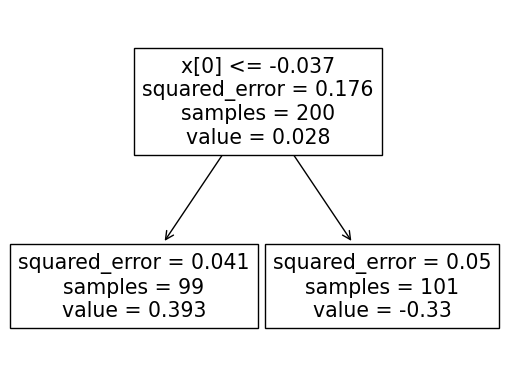

In [102]:
tree.plot_tree(tree_reg)

In [103]:
#Look the generated tree thresholds
######
tree_reg.tree_.threshold

array([-0.03733478, -2.        , -2.        ])

In [104]:
#The attributes of the trained tree that let us traverse, examine it
######

n_nodes = tree_reg.tree_.node_count

children_left = tree_reg.tree_.children_left
children_right = tree_reg.tree_.children_right

threshold = tree_reg.tree_.threshold


In [105]:
children_left

array([ 1, -1, -1], dtype=int64)

In [106]:
children_right

array([ 2, -1, -1], dtype=int64)

In [107]:
#Figure out which of these are split nodes and which are leaf nodes:
######

split_list = []

#Binary: Is this a split node?
node_splits = np.zeros(shape=n_nodes, dtype=np.int64)

for i in range(0, n_nodes):
    # If left and right child unequal, implies split
    if (children_left[i] != children_right[i]):
        split_list.append(i)
        
#Confirm it matches our visual inspection
split_list
    

[0]

In [109]:
##Can also get depth of each node as follows:
#Adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

stack = [(0, 0)]  # start with the root node id (0) and its depth (0)

#Save depth
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)

#While there are nodes on the stack
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    #Track our progrees
    print(node_id, depth)
    
    # Is this a split node? Note that the first node will always be a split node
    is_split_node = children_left[node_id] != children_right[node_id]
    
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1)) #Depth is one more than current
        stack.append((children_right[node_id], depth + 1))
        

0 0
2 1
1 1


In [110]:
#Node depths:
node_depth

array([0, 1, 1], dtype=int64)

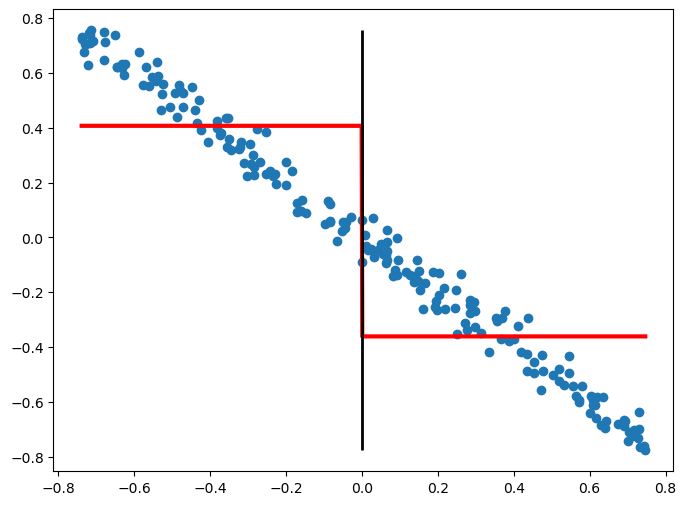

In [80]:
#Now we have enough info about the tree to visualize how results are determined:
########

#Get the predictions
y_pred = tree_reg.predict(x.reshape(-1,1))

#Plot
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
ax1.scatter(x,y)
ax1.plot(x, y_pred, '-r', linewidth=3)


#Different style depending on the depth
ls_dict = {0:'-', 1:'--', 2:':', 3:'-.'}

##vlines for decision boundaries:
for i, t in enumerate(tree_reg.tree_.threshold[split_list]):
    ax1.vlines(t, np.min(y), np.max(y), linestyle=ls_dict[node_depth[split_list[i]]], linewidth=2, color='black')


## Limitations on Out-of-Sample Predictions

Observe...

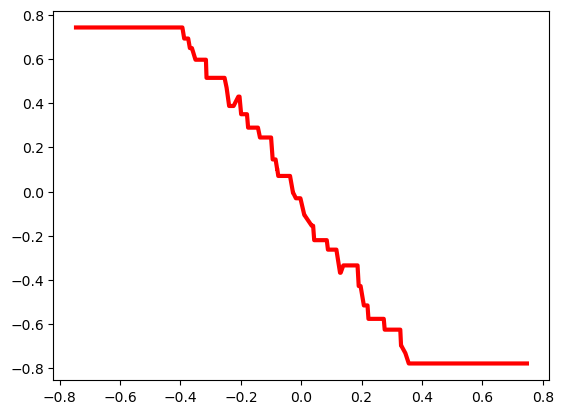

In [119]:
#From above:
x_test = np.random.uniform(-1.5,1.5,N)
x_test.sort()

y_pred = tree_reg.predict(x_test.reshape(-1,1))

#Plot
plt.plot(x, y_pred, '-r', linewidth=3)

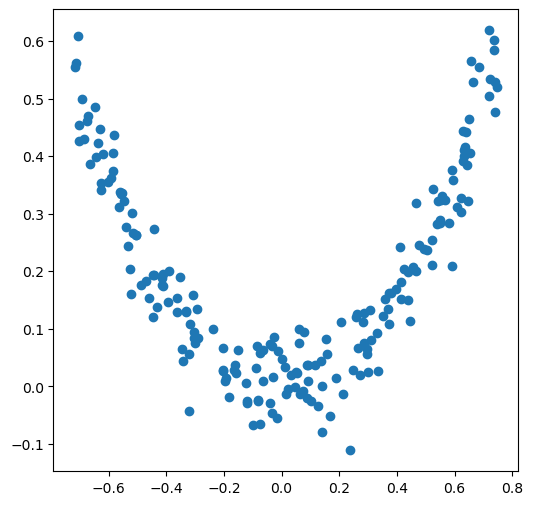

In [120]:
#And on polynomial data:
#####

N = 200

#Random x data
x = np.random.uniform(-.75,.75,N)
x.sort()

y = x**2 + np.random.normal(loc=0, scale=.05, size=N)

fig, ax1 = plt.subplots(1,1, figsize=(6, 6))
ax1.scatter(x,y)

In [121]:
#Make our tree regressor
######

tree_reg = DecisionTreeRegressor(max_depth=5) #, random_state=42)

tree_reg.fit(x.reshape(-1,1), y)

DecisionTreeRegressor(max_depth=5)

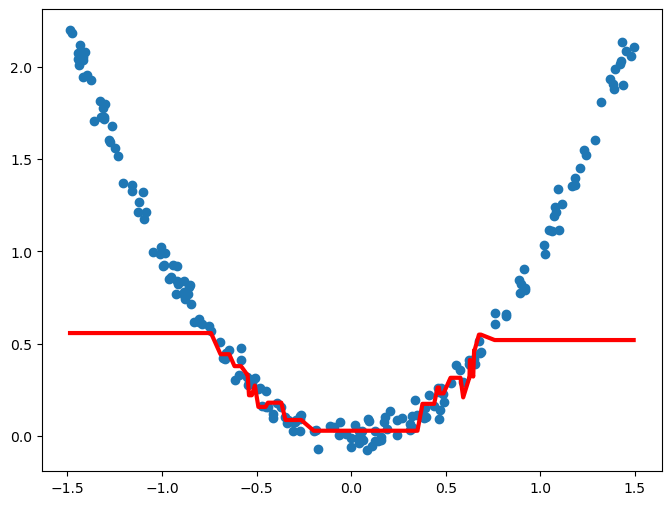

In [122]:
#Get predictions on a test dataset:
###
x_test = np.random.uniform(-1.5,1.5,N)
x_test.sort()

y_test = x_test**2 + np.random.normal(loc=0, scale=.05, size=N)

y_pred = tree_reg.predict(x_test.reshape(-1,1))

#Plot
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
ax1.scatter(x_test,y_test)
ax1.plot(x_test, y_pred, '-r', linewidth=3)

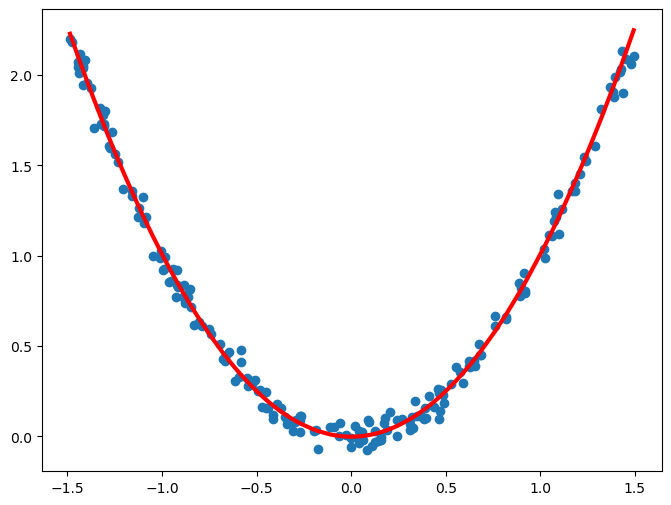

In [131]:
#Vs. a Linear Regression:
######
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_lr_reg = make_pipeline(PolynomialFeatures(degree=2),
                            StandardScaler(),
                            LinearRegression())

#Fit
poly_lr_reg.fit(x.reshape(-1,1), y)

#Predict
y_pred = poly_lr_reg.predict(x_test.reshape(-1,1))

#Plot
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
ax1.scatter(x_test,y_test)
ax1.plot(x_test, y_pred, '-r', linewidth=3)

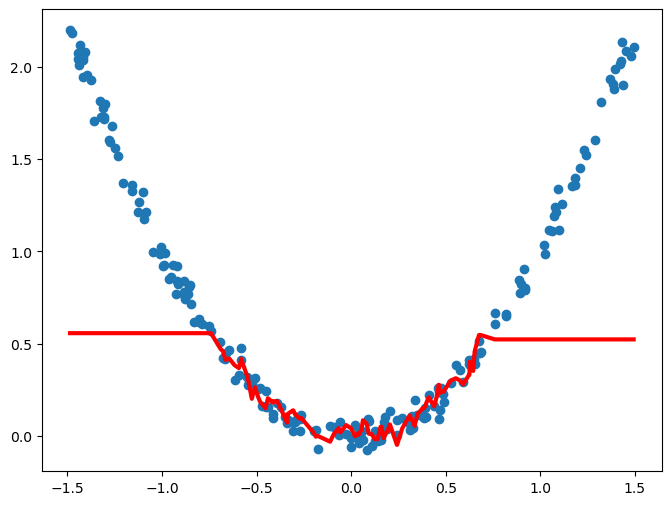

In [130]:
## This applies to random forests too:
#########
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg.fit(x.reshape(-1,1), y)

y_pred = forest_reg.predict(x_test.reshape(-1,1))

#Plot
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
ax1.scatter(x_test,y_test)
ax1.plot(x_test, y_pred, '-r', linewidth=3);


## Basic Classification Tree

- Let's use good old `iris`
- Classify flower based on petal length, say...

In [133]:
##Grab the data
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

#Dataframe of features
display(iris.data.head())

#And target:
display(iris.target.head())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [134]:
#For more info
#iris

In [135]:
#Function for the legend:
def make_iris_legend(ax):
    #Custom legend:
    #Get the cmap:
    from matplotlib import cm
    my_cmap = cm.get_cmap('viridis', 3)

    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    legend_elements = [Line2D([0], [0], markeredgecolor='black', markerfacecolor=my_cmap(0), marker='o', color='w', label='Setosa', markersize=12),
                       Line2D([0], [0], markeredgecolor='black', markerfacecolor=my_cmap(1), marker='o', color='w', label='Versicolor', markersize=12),
                       Line2D([0], [0], markeredgecolor='black',  markerfacecolor=my_cmap(2), marker='o', color='w', label='Virginica', markersize=12)]

    ax.legend(handles=legend_elements)


C:\Users\steff\AppData\Local\Temp\ipykernel_29892\3689415378.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap('viridis', 3)


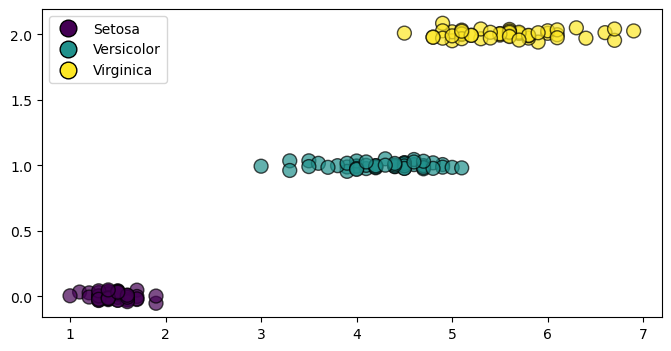

In [136]:
#Let's classify based on petal length only
#Get our X and y
X = iris.data[['petal length (cm)']]
y = iris.target


#Plot the data:
fig, ax1 = plt.subplots(1,1, figsize=(8, 4))

ax1.scatter(x=X, y=y+np.random.normal(0,.025,len(y)), c=y, s=100, edgecolor='black', alpha=.7)

make_iris_legend(ax1)


### And now for the Classification!

In [137]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2)

tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

[Text(0.4, 0.8333333333333334, 'x[0] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.6, 0.5, 'x[0] <= 4.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.043\nsamples = 45\nvalue = [0, 44, 1]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.194\nsamples = 55\nvalue = [0, 6, 49]')]

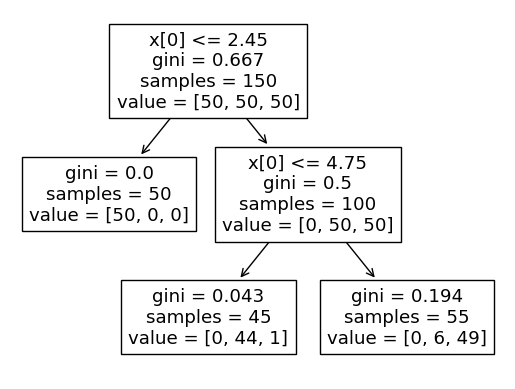

In [138]:
#Plot:
tree.plot_tree(tree_clf)

In [139]:
#And our decision boundaries:
#Put the stuff from above into a function:
def get_tree_stuff(t):

    n_nodes = t.tree_.node_count

    children_left = t.tree_.children_left
    children_right = t.tree_.children_right

    threshold = t.tree_.threshold


    split_list = []

    #Binary: Is this a split node?
    node_splits = np.zeros(shape=n_nodes, dtype=np.int64)

    for i in range(0, n_nodes):
        # If left and right child unequal, implies split
        if (children_left[i] != children_right[i]):
            split_list.append(i)

    
    
    ##Can also get depth of each node as follows:
    #Adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)

    #Save depth
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)

    #While there are nodes on the stack
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # Is this a split node? Note that the first node will always be a split node
        is_split_node = children_left[node_id] != children_right[node_id]

        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1)) #Depth is one more than current
            stack.append((children_right[node_id], depth + 1))


    return split_list, node_depth

In [140]:
#Run our function
split_list, node_depth = get_tree_stuff(tree_clf)


In [141]:
#We got?
split_list

[0, 2]

In [142]:
node_depth

array([0, 1, 1, 2, 2], dtype=int64)

C:\Users\steff\AppData\Local\Temp\ipykernel_29892\3689415378.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap('viridis', 3)


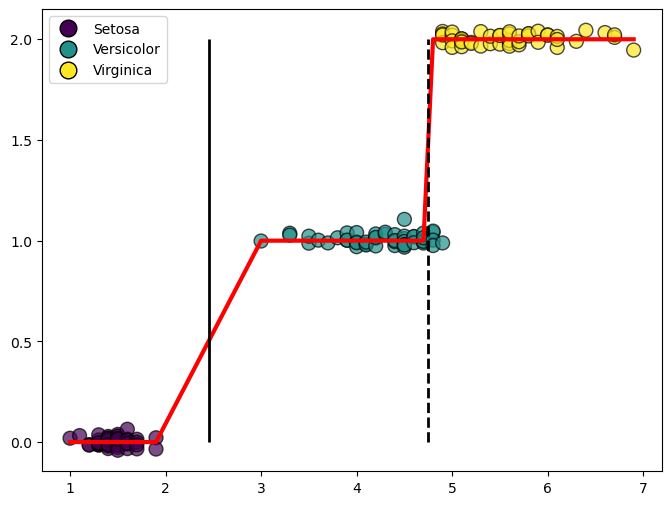

In [143]:
##Visualize similar to above:
######

#Now we have enough info about the tree to visualize how results are determined:
########

#Get the predictions
#Sort X for this:
X = X.sort_values(by = 'petal length (cm)')
y_pred = tree_clf.predict(X)

#Plot
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.scatter(x=X, y=y+np.random.normal(0,.025,len(y)), c=y, s=100, edgecolor='black', alpha=.7)
make_iris_legend(ax1)

ax1.plot(X, y_pred, '-r', linewidth=3)


#Different style depending on the depth
ls_dict = {0:'-', 1:'--', 2:':', 3:'-.'}

##vlines for decision boundaries:
for i, t in enumerate(tree_clf.tree_.threshold[split_list]):
    ax1.vlines(t, np.min(y), np.max(y), linestyle=ls_dict[node_depth[split_list[i]]], linewidth=2, color='black')

    

### Classify with two predictors?


In [165]:
X = iris.data[['petal length (cm)', 'petal width (cm)']]
y = iris.target

In [166]:
#Try 1 vs. 42 for random state
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42) #, criterion='entropy')

tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=4, random_state=42)

[Text(0.5, 0.9, 'x[0] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.4090909090909091, 0.7, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.5909090909090909, 0.7, 'x[1] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.36363636363636365, 0.5, 'x[0] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.18181818181818182, 0.3, 'x[1] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.09090909090909091, 0.1, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.2727272727272727, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.5454545454545454, 0.3, 'x[1] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.45454545454545453, 0.1, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.6363636363636364, 0.1, 'gini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(0.8181818181818182, 0.5, 'x[0] <= 4.85\ngini = 0.043\nsamples = 46\nvalue = [0, 1, 45]'),
 Text(0.7272727272727273, 0.3, 'gini =

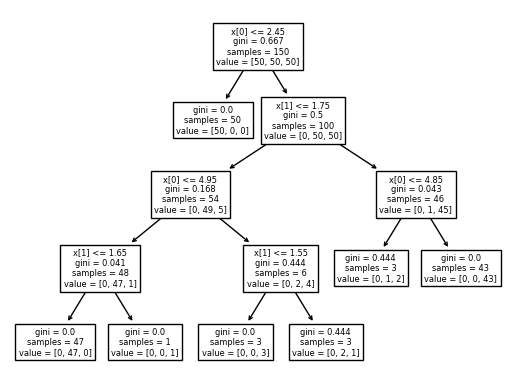

In [167]:
#Plot:
tree.plot_tree(tree_clf)

In [168]:
#How many do we get right?
(tree_clf.predict(X) == y).sum()

148

C:\Users\steff\Anaconda3\envs\ML_environment\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


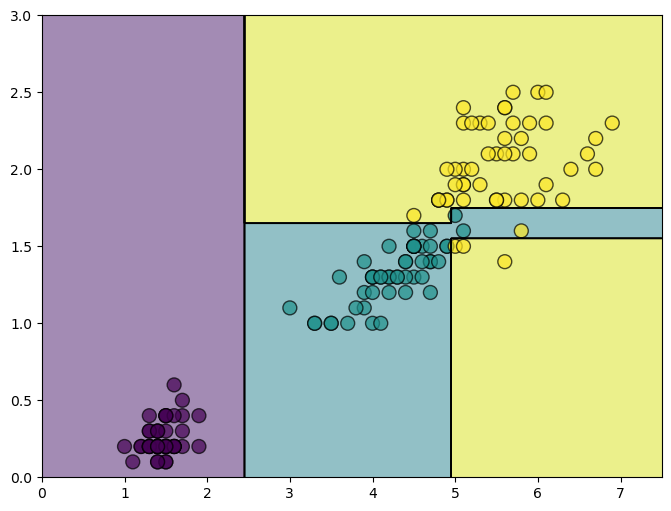

In [169]:
x1, x2 = np.meshgrid(np.linspace(0, 7.5, 1000),
                         np.linspace(0, 3, 1000))

X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = tree_clf.predict(X_new).reshape(x1.shape)


fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.contourf(x1, x2, y_pred, alpha=.5)
ax1.contour(x1, x2, y_pred, colors='black', alpha=1, linewidths=1)
ax1.scatter(x=X.iloc[:,0], y=X.iloc[:,1], c=y, s=100, edgecolor='black', alpha=.7)


### Class Probabilities

- Get probability of each class in the terminal leaf

In [158]:
#For example:

tree_clf.predict_proba(X)

array([[1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.

### Try on the Moons Data...

In [232]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=2000, noise=.65, random_state=42)

In [233]:
#Try 1 vs. 42 for random state
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42) #, criterion='entropy')

tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [234]:
from matplotlib.colors import ListedColormap
my_cmap = (ListedColormap(["red", "blue"]))

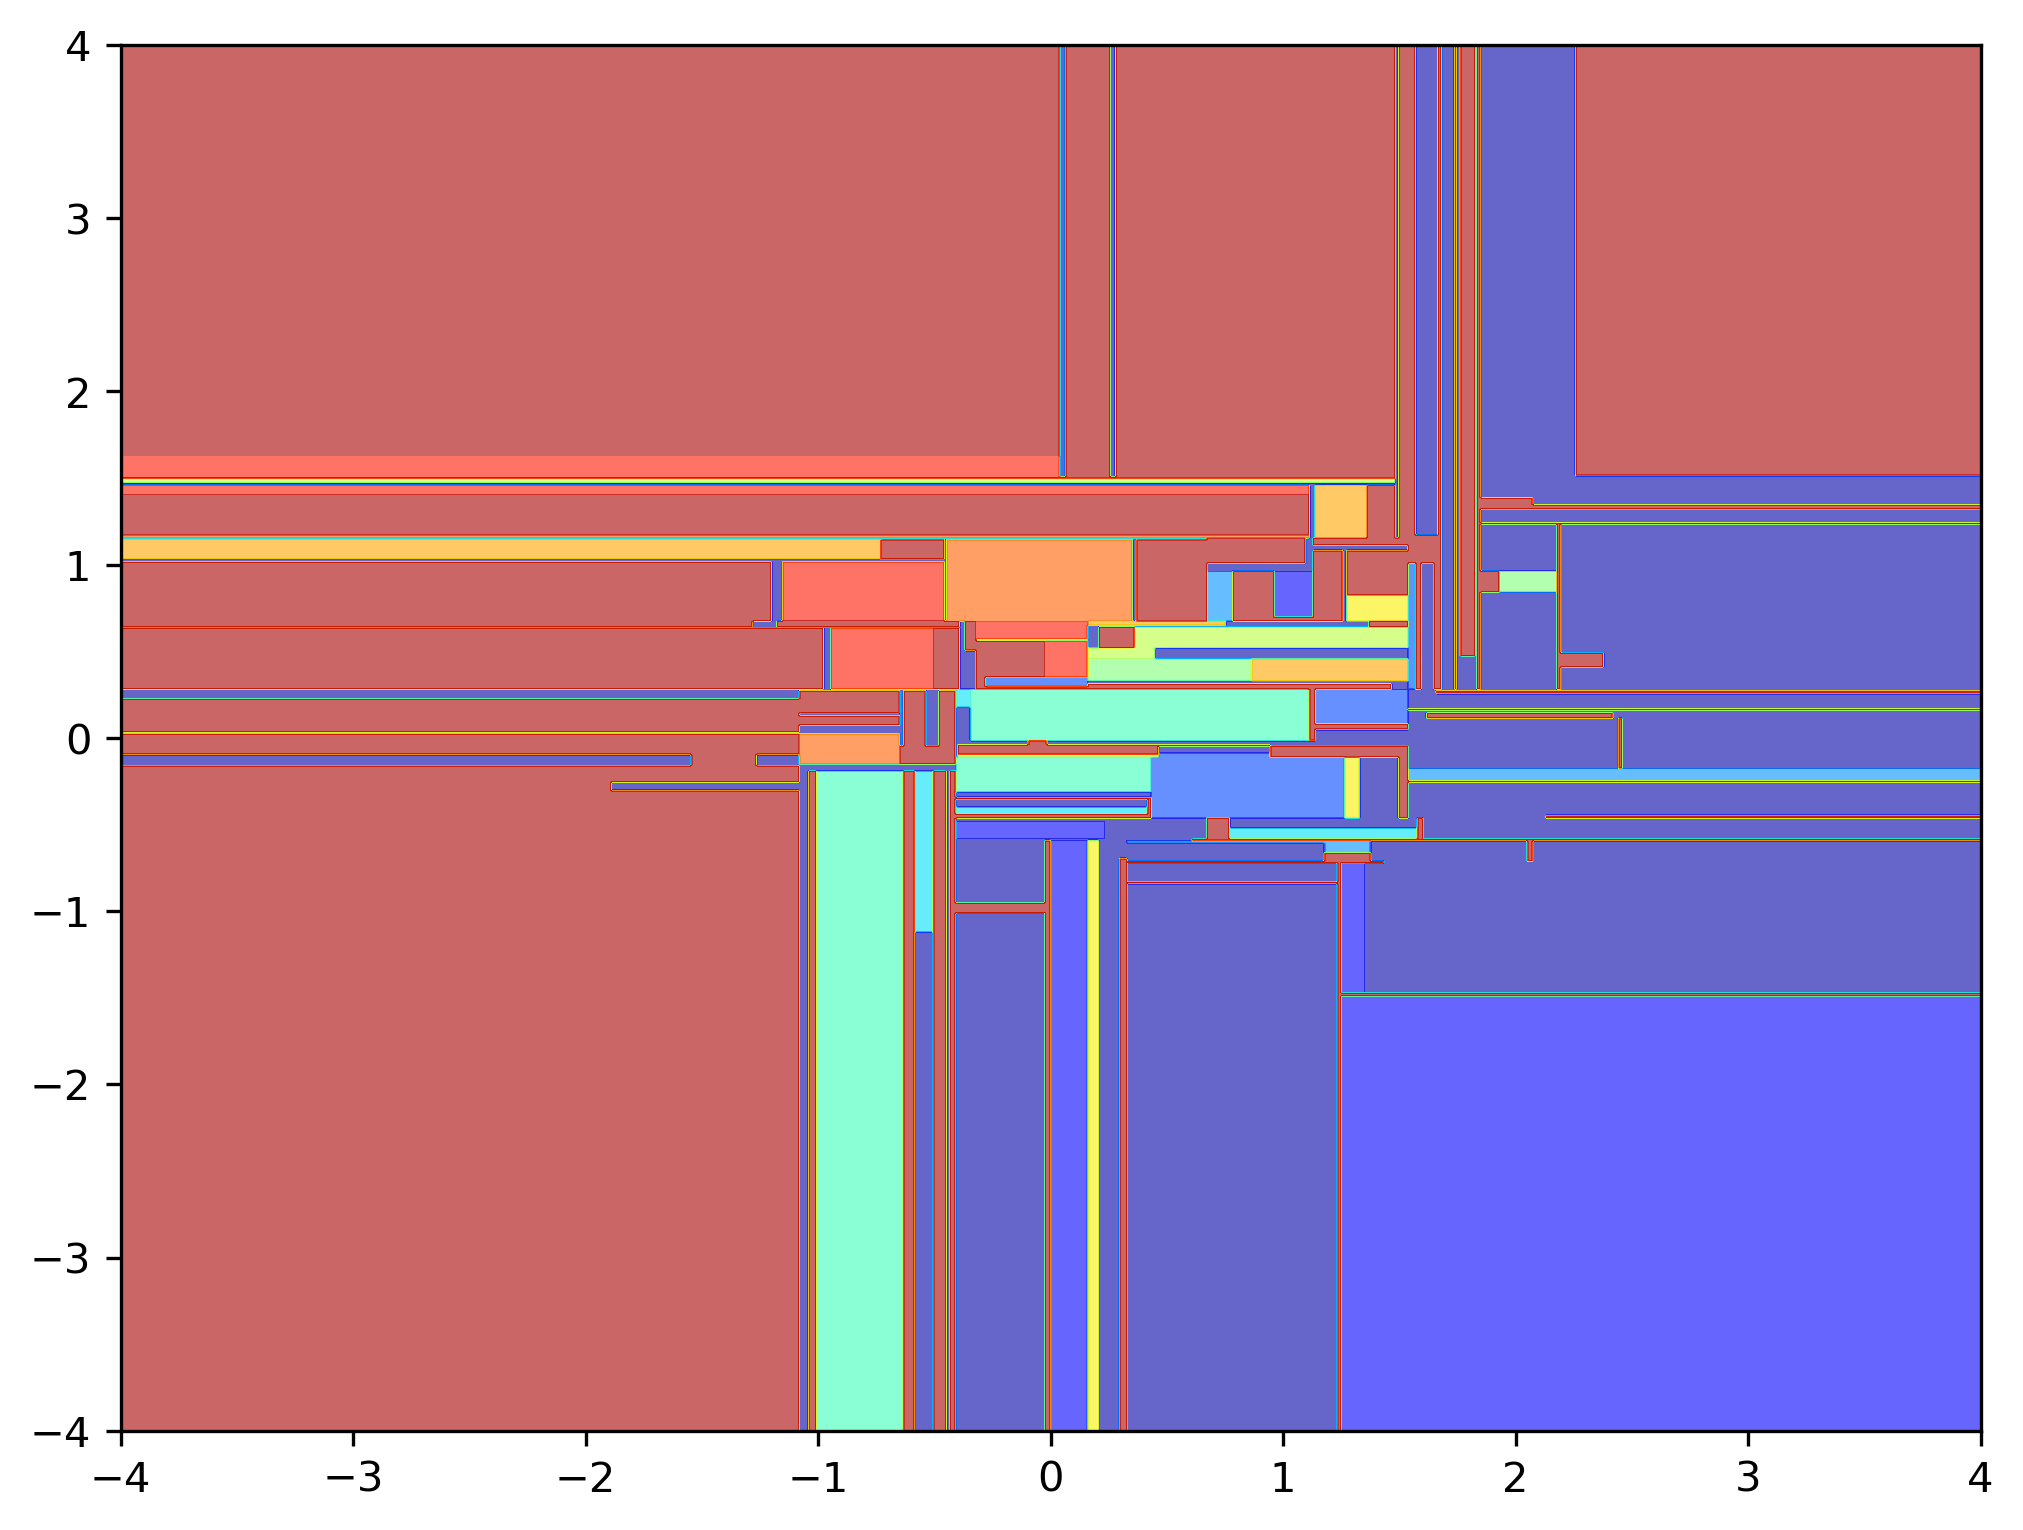

In [235]:
x1, x2 = np.meshgrid(np.linspace(-4, 4, 1000),
                         np.linspace(-4, 4, 1000))

X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = tree_clf.predict_proba(X_new)[:,0].reshape(x1.shape)


fig, ax1 = plt.subplots(1,1, figsize=(8, 6), dpi=300)

ax1.contourf(x1, x2, y_pred, 15, alpha=.6, cmap='jet')
#ax1.contour(x1, x2, y_pred, colors='black', alpha=1, linewidths=1)
#ax1.scatter(x=X[:,0], y=X[:,1], c=y, s=10, edgecolor='face', alpha=.3, cmap=my_cmap)
